# Sentiment Analysis with Neural Networks

One of the common uses for binary classification in machine learning is analyzing text for sentiment — specifically, assigning a text string a score from 0 to 1, where 0 represents negative sentiment and 1 represents positive sentiment. A restaurant review such as "Best meal I've ever had and awesome service, too!" might score 0.9 or higher, while a statement such as "Long lines and poor customer service" would score closer to 0. Marketing departments sometimes use sentiment-anlysis models to monitor social-media services for feedback so they can respond quickly if, for example, comments regarding their company suddenly turn negative.

To train a neural network to perform sentiment analysis, you need a dataset containing text strings labeled with 0s (for negative sentiment) and 1s (for positive sentiment). Several such datasets are available in the public domain. We will use one containing 50,000 movie reviews, each labeled with a 0 or 1. Once the network is trained, scoring a text string for sentiment is a simple matter of passing it to the network and asking for the probability that the predicted label is 1. A probability of 80% means the sentiment score is 0.8 and that the text is very positive.

## Load and prepare the data

The first step is to load the dataset and prepare it for use in machine learning. There's no need to tokenize the text since we'll use a [`TextVectorization`](https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/) layer to do the tokenizing.

In [1]:
import pandas as pd

df = pd.read_csv('Data/reviews.csv', encoding="ISO-8859-1")
df = df.sample(frac=1, random_state=0)
df.head()

,Text,Sentiment
11841,Al Pacino was once an actor capable of making ...,0
19602,After Chaplin made one of his best films: Doug...,0
45519,This movie is sort of a Carrie meets Heavy Met...,1
25747,I have fond memories of watching this visually...,1
42642,"In the '70s, Charlton Heston starred in sci-fi...",1


Remove duplicate rows and check for balance.

In [2]:
df = df.drop_duplicates()
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          24697  24697  American Graffiti is one of the best movies ev...   
1          24884  24884  John Thaw is a an excellent actor. I have to a...   

                
          freq  
Sentiment       
0            1  
1            1

## Train a neural network

Create a neural network containing a `TextVectorization` layer for vectorizing text, an [Embedding](https://keras.io/api/layers/core_layers/embedding/) layer for converting sequences into arrays of word vectors, and a [Dense](https://keras.io/api/layers/core_layers/dense/) layer for classifying arrays of word vectors.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, InputLayer
from tensorflow.keras.layers import Dense, Flatten, Embedding
import tensorflow as tf

max_words = 20000
max_length = 500
 
model = Sequential()
model.add(InputLayer(input_shape=(1,), dtype=tf.string))
model.add(TextVectorization(max_tokens=max_words, output_sequence_length=max_length))
model.add(Embedding(max_words, 32, input_length=max_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 32)           640000    
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 128)               2048128   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,688,257
Trainable params: 2,688,257
Non-trainable params: 0
______________________________________________

Extract text from the "Text" column and labels from the "Sentiment" column. Fit the `TextVectorization` layer to the text, and then train the network and capture the training history returned by `fit`.

In [4]:
x = df['Text']
y = df['Sentiment']
model.layers[0].adapt(x)

hist = model.fit(x, y, validation_split=0.5, epochs=5, batch_size=250)

Epoch 1/5
100/100 [==============================] - 6s 50ms/step - loss: 0.6207 - accuracy: 0.6231 - val_loss: 0.3896 - val_accuracy: 0.8201
Epoch 2/5
100/100 [==============================] - 5s 51ms/step - loss: 0.2360 - accuracy: 0.9047 - val_loss: 0.2903 - val_accuracy: 0.8788
Epoch 3/5
100/100 [==============================] - 5s 51ms/step - loss: 0.0703 - accuracy: 0.9814 - val_loss: 0.3535 - val_accuracy: 0.8706
Epoch 4/5
100/100 [==============================] - 5s 53ms/step - loss: 0.0187 - accuracy: 0.9977 - val_loss: 0.3733 - val_accuracy: 0.8780
Epoch 5/5
100/100 [==============================] - 6s 59ms/step - loss: 0.0062 - accuracy: 0.9997 - val_loss: 0.4090 - val_accuracy: 0.8752


See how the training and validation accuracy evolved and make sure the network was trained for a sufficient number of epochs.

[]

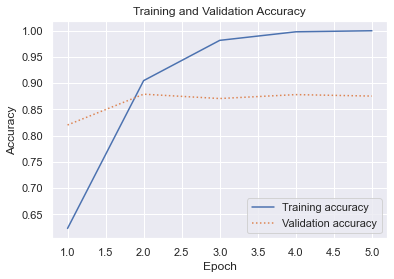

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Use the model to analyze text

Let's score a couple of reviews by passing them to the model's `predict` method. Start with a positive review.

In [6]:
text = 'Excellent food and fantastic service!'
model.predict([text])[0][0]

0.9772681

And then a negative review.

In [7]:
text = 'The long lines and poor customer service really turned me off.'
model.predict([text])[0][0]

0.11085078

Do the sentiment scores output by the model seem accurate?